In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import sys

sys.path.append('../../../code')
from load_data import *

TEAM_NAME = "Bayer Leverkusen"
COMPETITION_ID = 9      # Bundesliga
SEASON_ID = 281         # 2023/24 season
BASE_DIR = "../../../data/open-data/data"
MAX_MATCHES = None

# Section 1: Dataset Overview

In [39]:
matches = load_team_matches(
    team_name=TEAM_NAME,
    competition_id=COMPETITION_ID,
    season_id=SEASON_ID,
    base_dir=BASE_DIR
)
matches_with_360 = find_matches_with_360(matches, base_dir=BASE_DIR)

print(f"Matches found for '{TEAM_NAME}': {len(matches)}")
print(f"Matches with 360 available:     {len(matches_with_360)}")

matches_360 = [m for m in matches if m["match_id"] in set(matches_with_360)]
matches_360_df = pd.DataFrame(matches_360).sort_values(["match_date", "match_id"])

display(matches_360_df.head(3))


Matches found for 'Bayer Leverkusen': 34
Matches with 360 available:     34


,match_id,match_date,home_team,away_team,home_score,away_score,is_home,competition_id,season_id,competition_name,season_name
33,3895052,2023-08-19,Bayer Leverkusen,RB Leipzig,3,2,True,9,281,1. Bundesliga,2023/2024
32,3895060,2023-08-26,Borussia Mönchengladbach,Bayer Leverkusen,0,3,False,9,281,1. Bundesliga,2023/2024
31,3895067,2023-09-02,Bayer Leverkusen,Darmstadt 98,5,1,True,9,281,1. Bundesliga,2023/2024


In [40]:
combined_events_df, combined_freeze_frames_df, player_stats = load_all_team_data(
    team_name=TEAM_NAME,
    matches=matches_360,
    matches_with_360=matches_with_360,
    base_dir=BASE_DIR,
    max_matches=MAX_MATCHES
)

print("number of matches:", len(matches_360))
print("Loaded events:", len(combined_events_df))
print("Loaded freeze-frame rows:", len(combined_freeze_frames_df))
print("Players tracked:", len(player_stats))

display(combined_events_df.head())


number of matches: 34
Loaded events: 81440
Loaded freeze-frame rows: 1181537
Players tracked: 24


,event_id,match_id,team,player,type,minute,second,location,freeze_frame,visible_area,end_location,pass_outcome,is_complete,pass_recipient,pass_height,pass_type,player_id,position
0,794ec549-5288-4d1a-93e8-0fc6d3968784,3895302,Bayer Leverkusen,None,Starting XI,0,0,None,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1f956a2b-ece0-475b-8802-e82ed922c307,3895302,Bayer Leverkusen,None,Half Start,0,0,None,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cfa1f5e1-4e8e-4fc2-bbc8-4df5fdef8283,3895302,Bayer Leverkusen,Amine Adli,Pressure,0,9,"[85.5, 15.4]","[{'teammate': False, 'actor': False, 'keeper':...","[62.93333229134909, 51.86733377543315, 63.4877...",NaN,NaN,NaN,NaN,NaN,NaN,33401.0,Left Attacking Midfield
3,a43fa179-91f5-4b22-9f74-7f20af0570e4,3895302,Bayer Leverkusen,Edmond Fayçal Tapsoba,Pressure,0,12,"[55.6, 14.8]","[{'teammate': True, 'actor': True, 'keeper': F...","[56.1869627760245, 47.301407450232034, 50.1282...",NaN,NaN,NaN,NaN,NaN,NaN,30606.0,Left Center Back
4,533ffee0-b9fc-4065-a9db-cb729523d926,3895302,Bayer Leverkusen,Jonathan Tah,Pressure,0,15,"[51.0, 15.8]","[{'teammate': True, 'actor': False, 'keeper': ...","[49.56201260049416, 50.80856566796838, 36.6254...",NaN,NaN,NaN,NaN,NaN,NaN,8221.0,Center Back


In [41]:
def pct(series: pd.Series) -> float:
    return 100.0 * series.mean()

def has_nonempty_list(x) -> bool:
    return isinstance(x, list) and len(x) > 0

def dataset_health_table(events_df: pd.DataFrame, ff_df: pd.DataFrame) -> pd.DataFrame:
    out = []

    n_events = len(events_df)
    n_ff = len(ff_df)

    out.append(("n_events", n_events))
    out.append(("n_freeze_frame_rows", n_ff))

    if n_events > 0:
        out.append(("pct_events_with_location", pct(events_df["location"].notna())))
        out.append(("pct_events_with_freeze_frame", pct(events_df["freeze_frame"].apply(has_nonempty_list))))
        out.append(("pct_events_with_visible_area", pct(events_df["visible_area"].apply(has_nonempty_list))))

        if "player_id" in events_df.columns:
            out.append(("pct_events_with_player_id", pct(events_df["player_id"].notna())))
        if "position" in events_df.columns:
            out.append(("pct_events_with_position", pct(events_df["position"].notna())))

    if n_ff > 0:
        out.append(("pct_ff_rows_with_ff_location", pct(ff_df["ff_location"].notna())))
        out.append(("pct_ff_rows_teammate_notnull", pct(ff_df["teammate"].notna())))
        out.append(("pct_ff_rows_actor_true", 100.0 * (ff_df["actor"] == True).mean()))

    return pd.DataFrame(out, columns=["metric", "value"]).assign(
        value=lambda d: d["value"].round(2)
    )

health_df = dataset_health_table(combined_events_df, combined_freeze_frames_df)

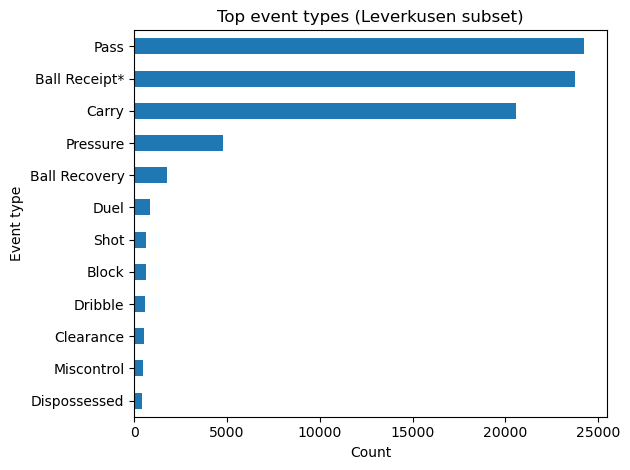

In [42]:
if len(combined_events_df) > 0:
    event_counts = combined_events_df["type"].value_counts().head(12)

    plt.figure()
    event_counts.sort_values().plot(kind="barh")
    plt.title("Top event types (Leverkusen subset)")
    plt.xlabel("Count")
    plt.ylabel("Event type")
    plt.tight_layout()
    plt.show()

In [43]:
top_players = (
    pd.DataFrame.from_dict(player_stats, orient="index")
      .reset_index()
      .rename(columns={"index": "player"})
      .sort_values("events", ascending=False)
      .head(15)
)

display(top_players)

,player,events,passes,matches
7,Granit Xhaka,10127,3299,33
11,Florian Wirtz,7234,1841,32
15,Alejandro Grimaldo García,6651,2159,33
14,Exequiel Alejandro Palacios,6514,2022,24
2,Jonathan Tah,6469,2167,31
1,Edmond Fayçal Tapsoba,5899,1946,27
9,Jonas Hofmann,5286,1528,32
3,Robert Andrich,4516,1501,28
6,Odilon Kossonou,4437,1422,22
10,Piero Martín Hincapié Reyna,4389,1423,25


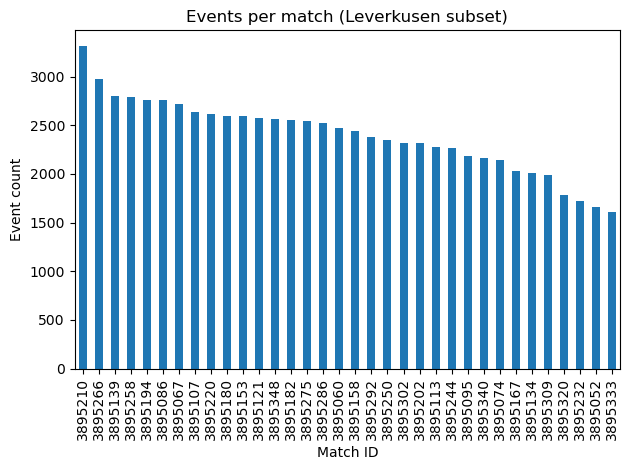

In [44]:
# If match_id is available, do per-match counts. Otherwise, skip.
per_match = combined_events_df.groupby("match_id").size().sort_values(ascending=False)

plt.figure()
per_match.plot(kind="bar")
plt.title("Events per match (Leverkusen subset)")
plt.xlabel("Match ID")
plt.ylabel("Event count")
plt.tight_layout()
plt.show()

In [45]:
def make_dataset_summary_table(events_df, team_name="Bayer Leverkusen"):
    """
    Create a compact summary table for Section 1.
    """
    n_matches = events_df["match_id"].nunique()
    n_events = len(events_df)
    n_passes = (events_df["type"] == "Pass").sum()
    n_carries = (events_df["type"] == "Carry").sum()
    n_players = events_df["player"].nunique()
    avg_events_per_match = round(n_events / n_matches, 1) if n_matches > 0 else 0

    summary = pd.DataFrame({
        "Statistic": [
            "Matches",
            "Total events",
            "Passes",
            "Carries",
            "Unique players",
            "Avg events per match"
        ],
        "Value": [
            n_matches,
            n_events,
            n_passes,
            n_carries,
            n_players,
            avg_events_per_match
        ]
    })

    return summary


# Generate table
summary_table = make_dataset_summary_table(combined_events_df)
display(summary_table)



,Statistic,Value
0,Matches,34.0
1,Total events,81440.0
2,Passes,24244.0
3,Carries,20593.0
4,Unique players,24.0
5,Avg events per match,2395.3


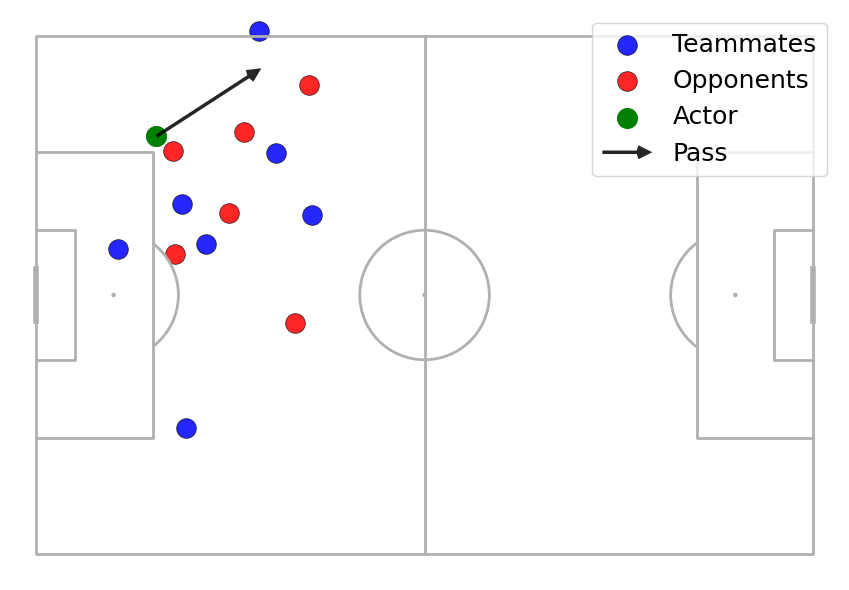

In [134]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

def plot_example_pass_freeze_frame_arrow(events_df, freeze_frames_df, random_state=42):
    """
    Plot one StatsBomb 360 freeze frame for a PASS event using mplsoccer,
    showing:
      - teammates and opponents
      - acting player
      - pass trajectory as an arrow
      - completion status encoded by line style (solid = complete, dashed = incomplete)
    """
    # Restrict to valid pass events with freeze-frame and locations
    valid = events_df[
        (events_df["type"] == "Pass") &
        (events_df["freeze_frame"].apply(lambda x: isinstance(x, list) and len(x) > 0)) &
        (events_df["location"].apply(lambda x: isinstance(x, (list, tuple)) and len(x) >= 2)) &
        (events_df["end_location"].apply(lambda x: isinstance(x, (list, tuple)) and len(x) >= 2))
    ].copy()

    if len(valid) == 0:
        raise ValueError("No PASS events with freeze-frame + (start,end) locations found.")

    row = valid.sample(n=1, random_state=random_state).iloc[0]

    ev_id = row["event_id"]
    actor_loc = row["location"]
    end_loc = row["end_location"]
    team = row.get("team", "")
    player = row.get("player", "")
    recipient = row.get("pass_recipient", None)
    minute = row.get("minute", None)
    second = row.get("second", None)

    # Completion flag
    is_complete = row.get("is_complete", None)
    outcome_str = "Completed" if is_complete == 1.0 else "Incomplete"

    # Freeze-frame points
    ff = freeze_frames_df[freeze_frames_df["event_id"] == ev_id].copy()
    teammates = ff[ff["teammate"] == True]
    opponents = ff[ff["teammate"] == False]

    pitch = Pitch(pitch_type="statsbomb", line_zorder=2)
    fig, ax = pitch.draw(figsize=(10, 6))

    # Teammates
    if len(teammates) > 0:
        pitch.scatter(
            teammates["ff_location"].apply(lambda x: x[0]),
            teammates["ff_location"].apply(lambda x: x[1]),
            ax=ax,
            c="blue",
            s=200,
            alpha=0.85,
            edgecolors="black",
            linewidth=0.5,
            label="Teammates"
        )

    # Opponents
    if len(opponents) > 0:
        pitch.scatter(
            opponents["ff_location"].apply(lambda x: x[0]),
            opponents["ff_location"].apply(lambda x: x[1]),
            ax=ax,
            c="red",
            s=200,
            alpha=0.85,
            edgecolors="black",
            linewidth=0.5,
            label="Opponents"
        )

    # Acting player
    pitch.scatter(
        actor_loc[0],
        actor_loc[1],
        ax=ax,
        c="green",
        s=200,
        label="Actor"
    )

    # Pass arrow (solid = complete, dashed = incomplete)
    linestyle = "-" if is_complete == 1.0 else "--"
    pitch.arrows(
        actor_loc[0],
        actor_loc[1],
        end_loc[0],
        end_loc[1],
        ax=ax,
        width=2.5,
        headwidth=4,
        headlength=4,
        color="black",
        linestyle=linestyle,
        alpha=0.85,
        label="Pass"
    )

    # Optional: nearest opponent pressure line
    # if len(opponents) > 0:
    #     opp_pts = np.vstack(opponents["ff_location"].values)
    #     dists = np.linalg.norm(opp_pts - np.array(actor_loc), axis=1)
    #     nearest_opp = opp_pts[np.argmin(dists)]
    #     pitch.lines(
    #         actor_loc[0], actor_loc[1],
    #         nearest_opp[0], nearest_opp[1],
    #         ax=ax,
    #         lw=1.2,
    #         linestyle=":",
    #         color="black",
    #         alpha=0.6,
    #         label="Nearest opponent"
    #     )

    # Title
    # time_str = f"{minute:02d}:{second:02d}" if (minute is not None and second is not None) else ""
    # rec_str = f" → {recipient}" if isinstance(recipient, str) and len(recipient) > 0 else ""
    # ax.set_title(
    #     f"Example pass freeze frame\n"
    #     f"{player}{rec_str} | {team} | {time_str}",
    #     fontsize=13
    # )

    # Clean legend (deduplicate labels)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=18)

    plt.tight_layout()
    plt.show()

    return row
example_pass = plot_example_pass_freeze_frame_arrow(
    combined_events_df,
    combined_freeze_frames_df,
    random_state=42
)


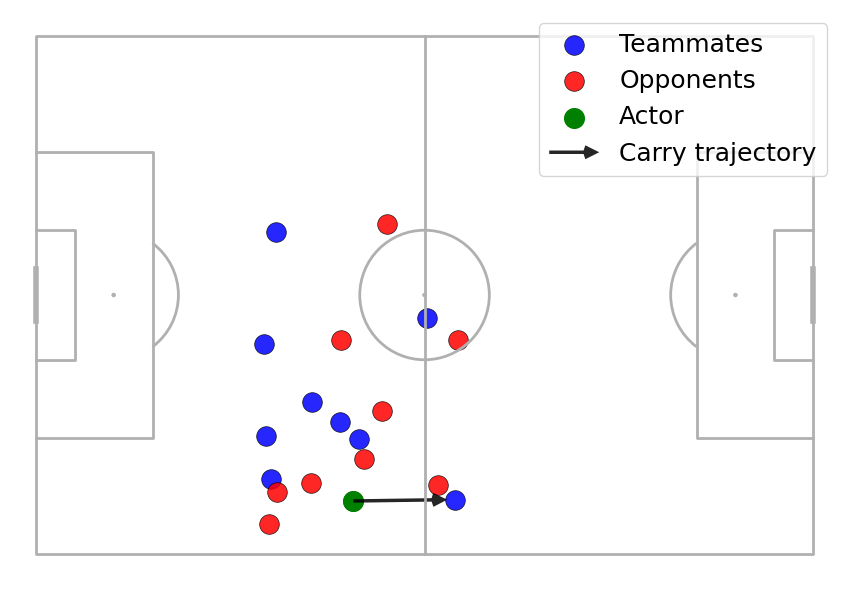

In [133]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

def plot_example_carry_freeze_frame_arrow(events_df, freeze_frames_df, random_state=42):
    """
    Plot one StatsBomb 360 freeze frame for a CARRY event using mplsoccer,
    showing:
      - teammates and opponents
      - acting player
      - carry trajectory as an arrow
    """
    # Restrict to valid carry events with freeze-frame and locations
    valid = events_df[
        (events_df["type"] == "Carry") &
        (events_df["freeze_frame"].apply(lambda x: isinstance(x, list) and len(x) > 0)) &
        (events_df["location"].apply(lambda x: isinstance(x, (list, tuple)) and len(x) >= 2)) &
        (events_df["end_location"].apply(lambda x: isinstance(x, (list, tuple)) and len(x) >= 2))
    ].copy()

    if len(valid) == 0:
        raise ValueError("No CARRY events with freeze-frame + (start,end) locations found.")

    row = valid.sample(n=1, random_state=random_state).iloc[0]

    ev_id = row["event_id"]
    actor_loc = row["location"]
    end_loc = row["end_location"]
    team = row.get("team", "")
    player = row.get("player", "")
    minute = row.get("minute", None)
    second = row.get("second", None)

    # Freeze-frame points
    ff = freeze_frames_df[freeze_frames_df["event_id"] == ev_id].copy()
    teammates = ff[ff["teammate"] == True]
    opponents = ff[ff["teammate"] == False]

    pitch = Pitch(pitch_type="statsbomb", line_zorder=2)
    fig, ax = pitch.draw(figsize=(10, 6))

    # Teammates
    if len(teammates) > 0:
        pitch.scatter(
            teammates["ff_location"].apply(lambda x: x[0]),
            teammates["ff_location"].apply(lambda x: x[1]),
            ax=ax,
            c="blue",
            s=200,
            alpha=0.85,
            edgecolors="black",
            linewidth=0.5,
            label="Teammates"
        )

    # Opponents
    if len(opponents) > 0:
        pitch.scatter(
            opponents["ff_location"].apply(lambda x: x[0]),
            opponents["ff_location"].apply(lambda x: x[1]),
            ax=ax,
            c="red",
            s=200,
            alpha=0.85,
            edgecolors="black",
            linewidth=0.5,
            label="Opponents"
        )

    # Acting player
    pitch.scatter(
        actor_loc[0],
        actor_loc[1],
        ax=ax,
        c="green",
        s=200,
        label="Actor"
    )

    # Carry arrow
    pitch.arrows(
        actor_loc[0],
        actor_loc[1],
        end_loc[0],
        end_loc[1],
        ax=ax,
        width=2.5,
        headwidth=4,
        headlength=4,
        color="black",
        alpha=0.85,
        label="Carry trajectory"
    )

    # # Optional: nearest opponent pressure line
    # if len(opponents) > 0:
    #     opp_pts = np.vstack(opponents["ff_location"].values)
    #     dists = np.linalg.norm(opp_pts - np.array(actor_loc), axis=1)
    #     nearest_opp = opp_pts[np.argmin(dists)]
    #     pitch.lines(
    #         actor_loc[0], actor_loc[1],
    #         nearest_opp[0], nearest_opp[1],
    #         ax=ax,
    #         lw=1.2,
    #         linestyle=":",
    #         color="black",
    #         alpha=0.6,
    #         label="Nearest opponent"
    #     )

    # Title
    # time_str = f"{minute:02d}:{second:02d}" if (minute is not None and second is not None) else ""
    # ax.set_title(
    #     f"Example carry freeze frame\n"
    #     f"{player} | {team} | {time_str}",
    #     fontsize=13
    # )

    # Clean legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=18)

    plt.tight_layout()
    plt.show()

    return row


example_carry = plot_example_carry_freeze_frame_arrow(
    combined_events_df,
    combined_freeze_frames_df,
    random_state=7
)


# Section 2: The Spatial 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

# StatsBomb pitch: 120 x 80
pitch = Pitch(pitch_type="statsbomb", line_zorder=2)

In [49]:
import numpy as np
import pandas as pd

def sanitize_visible_area(va):
    """
    Convert visible_area into an (N,2) float array of vertices.
    Returns None if the polygon cannot be formed safely.
    """
    if not isinstance(va, list):
        return None

    # Keep only finite numeric entries
    cleaned = []
    for v in va:
        try:
            fv = float(v)
            if np.isfinite(fv):
                cleaned.append(fv)
        except (TypeError, ValueError):
            # skip non-numeric entries like None, strings, etc.
            continue

    # Need an even number of values to form (x,y) pairs
    if len(cleaned) < 6 or (len(cleaned) % 2 != 0):
        return None

    pts = np.array(cleaned, dtype=float).reshape(-1, 2)

    # Need at least 3 vertices
    if pts.shape[0] < 3:
        return None

    return pts

def plot_visible_area_sample(events_df, n=6, random_state=0):
    # Identify candidates
    candidates = events_df[events_df["visible_area"].apply(lambda x: isinstance(x, list) and len(x) >= 6)].copy()
    if len(candidates) == 0:
        print("[NOTE] No events with visible_area lists found.")
        return

    # Sample more than n because some will be invalid after cleaning
    candidates = candidates.sample(n=min(len(candidates), max(n * 5, n)), random_state=random_state)

    shown = 0
    skipped = 0

    for _, row in candidates.iterrows():
        if shown >= n:
            break

        va = row["visible_area"]
        pts = sanitize_visible_area(va)

        if pts is None:
            skipped += 1
            continue

        fig, ax = pitch.draw(figsize=(10, 6))

        # mplsoccer polygon expects (N,2)
        pitch.polygon(pts, ax=ax, alpha=0.3)

        # Optional: plot the event location if present
        loc = row.get("location")
        x, y = extract_xy(loc)
        if x is not None and y is not None:
            pitch.scatter([x], [y], ax=ax, s=60)

        ax.set_title(f"Visible area | event={row.get('event_id')} | type={row.get('type')}")
        plt.show()

        shown += 1

    print(f"Displayed: {shown} polygons. Skipped (invalid after cleaning): {skipped}.")


In [50]:
def extract_xy(loc):
    if isinstance(loc, (list, tuple)) and len(loc) >= 2:
        x, y = loc[0], loc[1]
        if x is None or y is None:
            return None, None
        return float(x), float(y)
    return None, None

def series_to_xy(series):
    xs, ys = [], []
    for loc in series:
        x, y = extract_xy(loc)
        if x is not None and y is not None:
            xs.append(x); ys.append(y)
    return np.array(xs, dtype=float), np.array(ys, dtype=float)


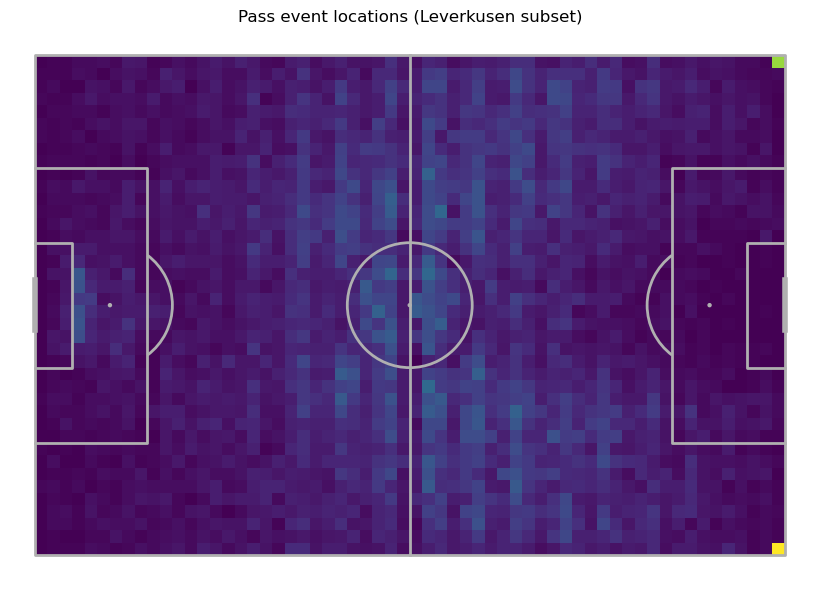

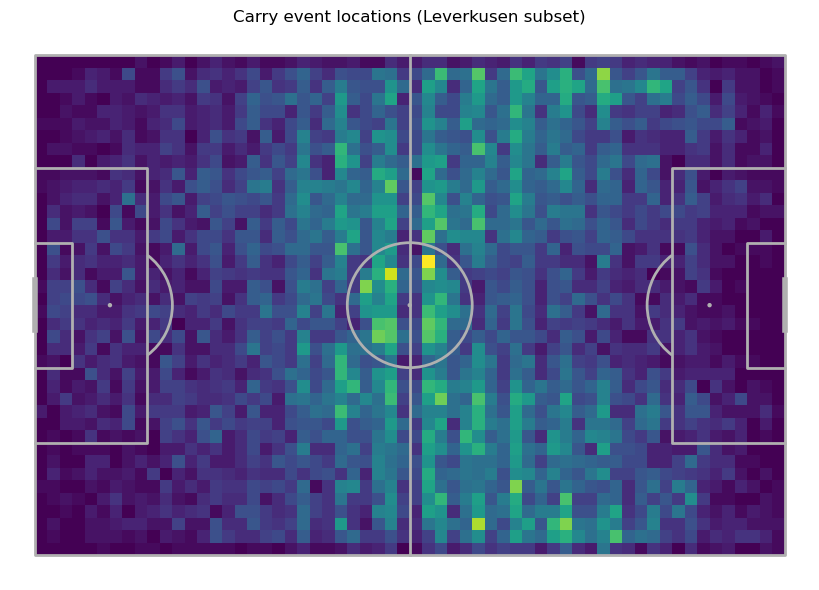

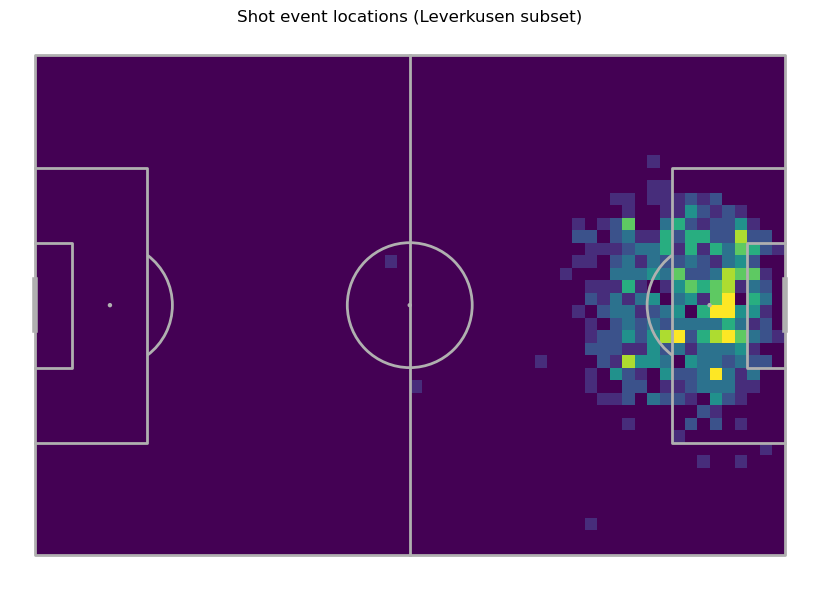

In [51]:
events_df = combined_events_df.copy()

def plot_event_location_heatmap(events_df, event_type, bins=(60, 40)):
    sub = events_df[events_df["type"] == event_type]
    x, y = series_to_xy(sub["location"].values)

    if len(x) == 0:
        print(f"[NOTE] No valid locations for {event_type}")
        return

    fig, ax = pitch.draw(figsize=(10, 6))
    stat = pitch.bin_statistic(x, y, statistic="count", bins=bins)
    pitch.heatmap(stat, ax=ax)
    ax.set_title(f"{event_type} event locations (Leverkusen subset)")
    plt.show()

for ev_type in ["Pass", "Carry", "Shot"]:
    plot_event_location_heatmap(events_df, ev_type)


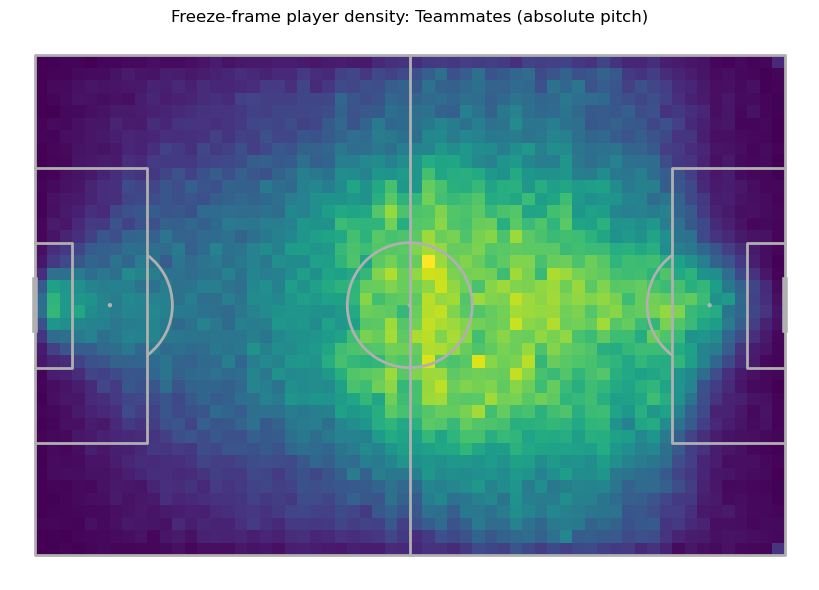

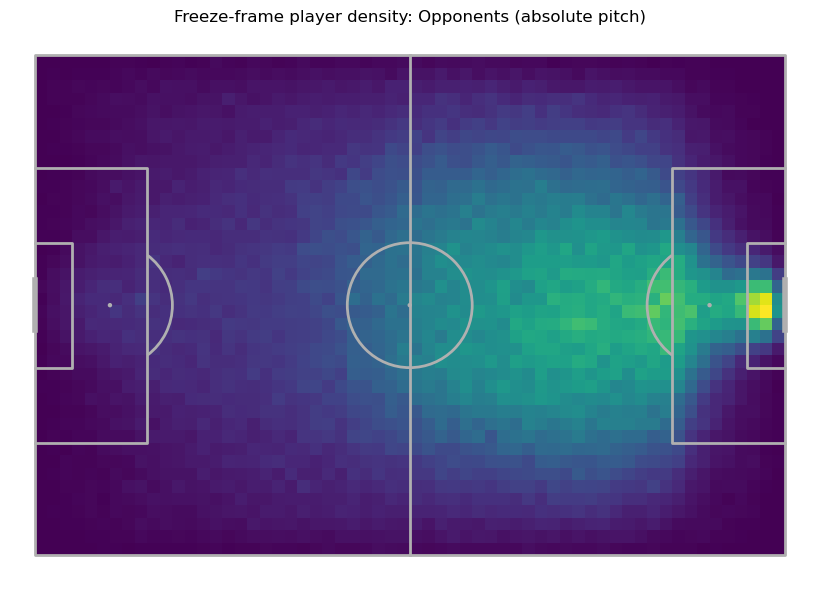

In [52]:
ff_df = combined_freeze_frames_df.copy()

# Extract freeze-frame x/y
ff_df["ff_x"] = ff_df["ff_location"].apply(lambda loc: extract_xy(loc)[0])
ff_df["ff_y"] = ff_df["ff_location"].apply(lambda loc: extract_xy(loc)[1])

ff_team = ff_df[ff_df["teammate"] == True].dropna(subset=["ff_x", "ff_y"])
ff_opp  = ff_df[ff_df["teammate"] == False].dropna(subset=["ff_x", "ff_y"])

def plot_ff_density_absolute(sub_df, title, bins=(60, 40)):
    x = sub_df["ff_x"].to_numpy()
    y = sub_df["ff_y"].to_numpy()

    fig, ax = pitch.draw(figsize=(10, 6))
    stat = pitch.bin_statistic(x, y, statistic="count", bins=bins)
    pitch.heatmap(stat, ax=ax)
    ax.set_title(title)
    plt.show()

plot_ff_density_absolute(ff_team, "Freeze-frame player density: Teammates (absolute pitch)")
plot_ff_density_absolute(ff_opp,  "Freeze-frame player density: Opponents (absolute pitch)")


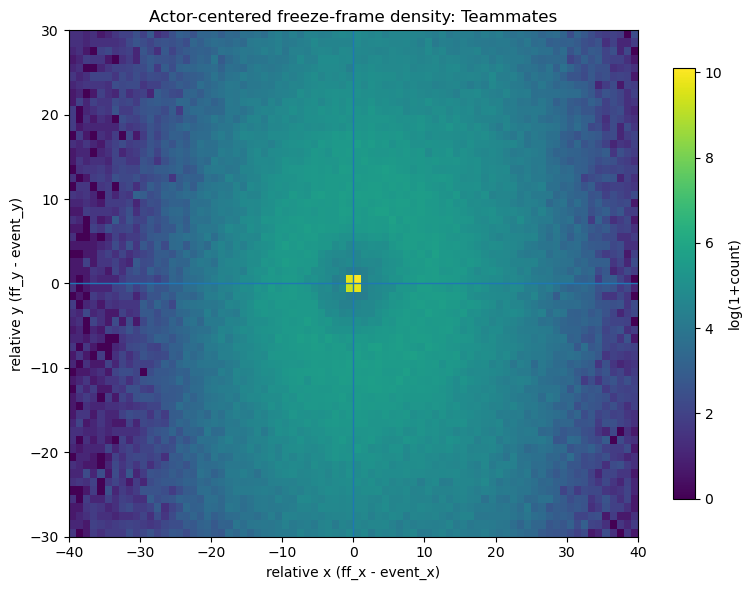

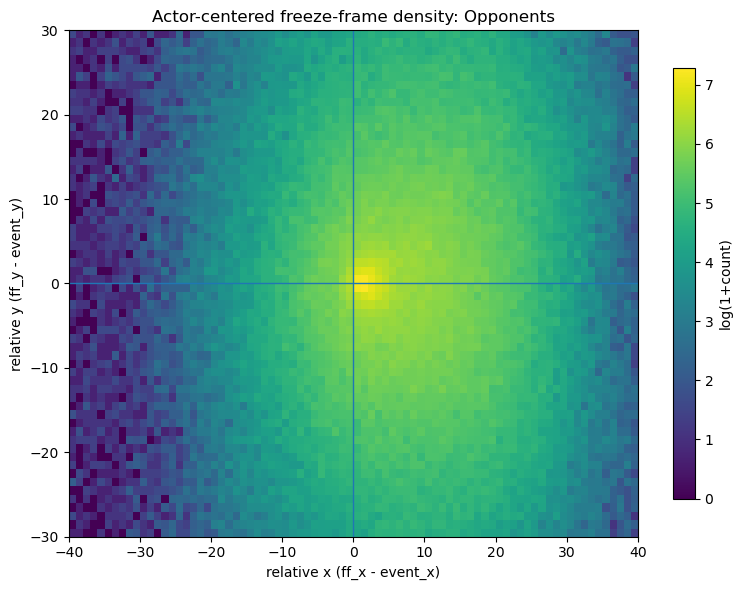

In [53]:
# event location from freeze frame df
ff_df["ev_x"] = ff_df["event_location"].apply(lambda loc: extract_xy(loc)[0])
ff_df["ev_y"] = ff_df["event_location"].apply(lambda loc: extract_xy(loc)[1])

ff_df["rel_x"] = ff_df["ff_x"] - ff_df["ev_x"]
ff_df["rel_y"] = ff_df["ff_y"] - ff_df["ev_y"]

rel_valid = ff_df.dropna(subset=["rel_x", "rel_y"])

REL_XLIM = (-40, 40)
REL_YLIM = (-30, 30)

def plot_actor_centered_density(sub_df, title, bins=(80, 60), xlim=REL_XLIM, ylim=REL_YLIM):
    x = sub_df["rel_x"].to_numpy()
    y = sub_df["rel_y"].to_numpy()

    # 2D histogram
    H, xedges, yedges = np.histogram2d(
        x, y,
        bins=bins,
        range=[xlim, ylim]
    )
    H = H.T  # for imshow

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(
        np.log1p(H),
        origin="lower",
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        aspect="auto"
    )
    ax.axvline(0, linewidth=1)
    ax.axhline(0, linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("relative x (ff_x - event_x)")
    ax.set_ylabel("relative y (ff_y - event_y)")
    fig.colorbar(im, ax=ax, shrink=0.85, label="log(1+count)")
    plt.tight_layout()
    plt.show()

rel_team = rel_valid[rel_valid["teammate"] == True]
rel_opp  = rel_valid[rel_valid["teammate"] == False]

plot_actor_centered_density(rel_team, "Actor-centered freeze-frame density: Teammates")
plot_actor_centered_density(rel_opp,  "Actor-centered freeze-frame density: Opponents")


# Section 3: Role-Based Context Differences

In [54]:
import numpy as np
import pandas as pd

ff_df = combined_freeze_frames_df.copy()

# Extract freeze-frame coordinates
def extract_xy(loc):
    if isinstance(loc, (list, tuple)) and len(loc) >= 2:
        x, y = loc[0], loc[1]
        if x is None or y is None:
            return None, None
        return float(x), float(y)
    return None, None

ff_df["ff_x"] = ff_df["ff_location"].apply(lambda loc: extract_xy(loc)[0])
ff_df["ff_y"] = ff_df["ff_location"].apply(lambda loc: extract_xy(loc)[1])

# Extract event (actor) location
ff_df["ev_x"] = ff_df["event_location"].apply(lambda loc: extract_xy(loc)[0])
ff_df["ev_y"] = ff_df["event_location"].apply(lambda loc: extract_xy(loc)[1])

# Compute distances from actor to each freeze-frame player
ff_df["dist_to_actor"] = np.sqrt(
    (ff_df["ff_x"] - ff_df["ev_x"])**2 +
    (ff_df["ff_y"] - ff_df["ev_y"])**2
)

# Filter to valid rows
ff_valid = ff_df.dropna(subset=["dist_to_actor", "teammate", "actor"]).copy()

# Split teammates and opponents (exclude actor themself)
ff_valid = ff_valid[ff_valid["actor"] == False]

# Aggregate per event
context_rows = []
for event_id, g in ff_valid.groupby("event_id"):
    teammates = g[g["teammate"] == True]
    opponents = g[g["teammate"] == False]

    row = {
        "event_id": event_id,
        "n_teammates_visible": len(teammates),
        "n_opponents_visible": len(opponents),
        "nearest_teammate_dist": teammates["dist_to_actor"].min() if len(teammates) > 0 else np.nan,
        "nearest_opponent_dist": opponents["dist_to_actor"].min() if len(opponents) > 0 else np.nan,
        "mean_teammate_dist": teammates["dist_to_actor"].mean() if len(teammates) > 0 else np.nan,
        "mean_opponent_dist": opponents["dist_to_actor"].mean() if len(opponents) > 0 else np.nan,
        "n_opponents_within_5m": (opponents["dist_to_actor"] <= 5).sum(),
        "n_opponents_within_10m": (opponents["dist_to_actor"] <= 10).sum(),
    }
    context_rows.append(row)

context_df = pd.DataFrame(context_rows)

# Merge context metrics back into events_df
events_ctx = combined_events_df.merge(context_df, on="event_id", how="left")

display(events_ctx.head())


,event_id,match_id,team,player,type,minute,second,location,freeze_frame,visible_area,...,player_id,position,n_teammates_visible,n_opponents_visible,nearest_teammate_dist,nearest_opponent_dist,mean_teammate_dist,mean_opponent_dist,n_opponents_within_5m,n_opponents_within_10m
0,794ec549-5288-4d1a-93e8-0fc6d3968784,3895302,Bayer Leverkusen,None,Starting XI,0,0,None,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1f956a2b-ece0-475b-8802-e82ed922c307,3895302,Bayer Leverkusen,None,Half Start,0,0,None,[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cfa1f5e1-4e8e-4fc2-bbc8-4df5fdef8283,3895302,Bayer Leverkusen,Amine Adli,Pressure,0,9,"[85.5, 15.4]","[{'teammate': False, 'actor': False, 'keeper':...","[62.93333229134909, 51.86733377543315, 63.4877...",...,33401.0,Left Attacking Midfield,3.0,6.0,12.152010,4.147836,19.199220,18.981622,1.0,1.0
3,a43fa179-91f5-4b22-9f74-7f20af0570e4,3895302,Bayer Leverkusen,Edmond Fayçal Tapsoba,Pressure,0,12,"[55.6, 14.8]","[{'teammate': True, 'actor': True, 'keeper': F...","[56.1869627760245, 47.301407450232034, 50.1282...",...,30606.0,Left Center Back,6.0,7.0,8.623877,1.962751,21.092334,19.060474,1.0,2.0
4,533ffee0-b9fc-4065-a9db-cb729523d926,3895302,Bayer Leverkusen,Jonathan Tah,Pressure,0,15,"[51.0, 15.8]","[{'teammate': True, 'actor': False, 'keeper': ...","[49.56201260049416, 50.80856566796838, 36.6254...",...,8221.0,Center Back,9.0,7.0,6.550906,2.429098,15.160624,15.579516,1.0,1.0


In [55]:
def list_raw_positions(events_df, min_count=1, sort=True):
    """
    List all unique StatsBomb position labels and their frequencies.

    Args:
        events_df: combined_events_df (must include 'position')
        min_count: only show positions with at least this many events
        sort: whether to sort descending by count

    Returns:
        DataFrame with columns: position, freq
    """
    pos_counts = (
        events_df["position"]
        .fillna("None")
        .value_counts()
        .rename("freq")     # name the Series explicitly
        .reset_index()
        .rename(columns={"index": "position"})
    )

    if min_count > 1:
        pos_counts = pos_counts[pos_counts["freq"] >= min_count]

    if sort:
        pos_counts = pos_counts.sort_values("freq", ascending=False)

    return pos_counts


raw_pos_df = list_raw_positions(combined_events_df, min_count=1)
raw_pos_df['position'].unique()

array(['Right Defensive Midfield', 'Left Defensive Midfield',
       'Left Center Back', 'Right Center Back', 'Center Back',
       'Left Wing Back', 'Left Attacking Midfield', 'Right Wing Back',
       'Right Attacking Midfield', 'Center Forward', 'Goalkeeper',
       'Right Wing', 'Left Wing', 'Center Attacking Midfield',
       'Left Center Forward', 'None', 'Right Center Forward', 'Left Back',
       'Right Midfield', 'Right Back', 'Right Center Midfield'],
      dtype=object)

In [56]:
import re
import pandas as pd

def map_position_to_role_sb(position: str):
    """
    Map StatsBomb position strings to coarse roles.

    Returns one of:
      GK, CB, FB, WB, DM, CM, AM, W, ST, Other, None
    """
    if position is None or (isinstance(position, float) and pd.isna(position)):
        return None

    pos = str(position).strip()
    if pos.lower() == "none":
        return None

    p = pos.lower()

    # Goalkeeper
    if "goalkeeper" in p:
        return "GK"

    # Center Back variants
    if "center back" in p or "centre back" in p:
        return "CB"

    # Wing backs
    if "wing back" in p:
        return "WB"

    # Full backs
    # (StatsBomb uses Left Back / Right Back as fullbacks too)
    if p in ["left back", "right back"] or "full back" in p:
        return "FB"

    # Defensive midfield
    if "defensive midfield" in p:
        return "DM"

    # Central midfield
    if "center midfield" in p or "centre midfield" in p or "central midfield" in p:
        return "CM"

    # Attacking midfield
    if "attacking midfield" in p:
        # includes Left/Right/Center Attacking Midfield
        return "AM"

    # Wings / wide players
    # Right Wing, Left Wing; Right Midfield / Left Midfield (often wide mids)
    if re.search(r"\bleft wing\b|\bright wing\b", p):
        return "W"
    if re.search(r"\bleft midfield\b|\bright midfield\b", p):
        return "W"

    # Forwards / strikers
    if "center forward" in p or "centre forward" in p:
        return "ST"
    if re.search(r"\bleft center forward\b|\bright center forward\b", p):
        return "ST"
    if "striker" in p or "forward" == p:
        return "ST"

    return "Other"

events_ctx["role_v2"] = events_ctx["position"].apply(map_position_to_role_sb)
display(events_ctx["role_v2"].value_counts(dropna=False))


role_v2
CB      24417
DM      20621
WB      13168
AM      11605
ST       5154
W        3678
GK       2395
None      245
FB        148
CM          9
Name: count, dtype: int64

In [57]:
role_summary = (
    events_ctx
    .dropna(subset=["role_v2"])
    .groupby("role_v2")
    .agg(
        n_events=("event_id", "count"),
        avg_nearest_opponent_dist=("nearest_opponent_dist", "mean"),
        avg_nearest_teammate_dist=("nearest_teammate_dist", "mean"),
        avg_opponents_within_5m=("n_opponents_within_5m", "mean"),
        avg_opponents_within_10m=("n_opponents_within_10m", "mean"),
        avg_visible_opponents=("n_opponents_visible", "mean"),
        avg_visible_teammates=("n_teammates_visible", "mean"),
    )
    .reset_index()
)

display(role_summary.round(2))


,role_v2,n_events,avg_nearest_opponent_dist,avg_nearest_teammate_dist,avg_opponents_within_5m,avg_opponents_within_10m,avg_visible_opponents,avg_visible_teammates
0,AM,11605,7.69,12.11,0.91,2.30,8.95,7.09
1,CB,24417,8.52,11.46,0.38,1.08,8.07,7.47
2,CM,9,6.00,8.77,0.67,0.83,7.83,8.17
3,DM,20621,6.20,9.35,0.69,2.07,8.67,7.57
4,FB,148,9.65,14.11,0.65,1.85,8.94,6.70
5,GK,2395,14.38,12.88,0.17,0.61,5.05,6.42
6,ST,5154,11.70,16.70,1.04,2.42,8.62,6.59
7,W,3678,8.31,12.62,0.86,2.30,8.80,6.91
8,WB,13168,8.79,13.50,0.65,1.61,8.61,6.96


/var/folders/vd/j_d7xxb56hg064_h1h3mkqt80000gn/T/ipykernel_14260/2347766420.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df["role"] = pd.Categorical(plot_df["role_v2"], ordered=True)


<Figure size 1000x600 with 0 Axes>

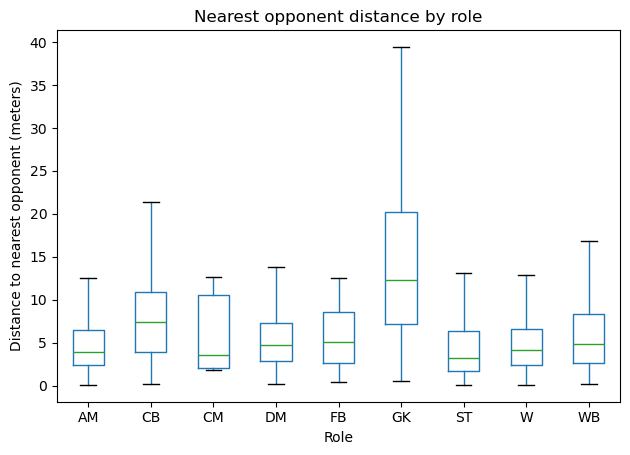

In [58]:
import matplotlib.pyplot as plt

plot_df = events_ctx.dropna(subset=["role_v2", "nearest_opponent_dist"])


plot_df["role"] = pd.Categorical(plot_df["role_v2"], ordered=True)
plot_df = plot_df.sort_values("role")

plt.figure(figsize=(10, 6))
plot_df.boxplot(
    column="nearest_opponent_dist",
    by="role",
    grid=False,
    showfliers=False
)
plt.suptitle("")
plt.title("Nearest opponent distance by role")
plt.xlabel("Role")
plt.ylabel("Distance to nearest opponent (meters)")
plt.tight_layout()
plt.show()


In [59]:
import numpy as np
import pandas as pd

def _xy(loc):
    """Safely extract (x,y) from a StatsBomb location list."""
    if isinstance(loc, (list, tuple)) and len(loc) >= 2:
        return float(loc[0]), float(loc[1])
    return np.nan, np.nan

def build_context_features(events_df, freeze_frames_df, radius=10.0):
    """
    Returns an events-level dataframe with:
      - nearest_opp_dist: distance to nearest opponent in freeze frame
      - opp_within_r: number of opponents within `radius` of the actor
    Notes:
      - Uses freeze_frames_df, restricting to non-teammates (opponents).
      - Computes features for events with a valid actor location and >=1 opponent.
    """
    ev = events_df.copy()

    # Actor location
    actor_xy = ev["location"].apply(_xy)
    ev["x"] = actor_xy.apply(lambda t: t[0])
    ev["y"] = actor_xy.apply(lambda t: t[1])

    # Opponent locations per event
    ff = freeze_frames_df.copy()
    ff = ff[ff["teammate"] == False].copy()

    ff_xy = ff["ff_location"].apply(_xy)
    ff["ox"] = ff_xy.apply(lambda t: t[0])
    ff["oy"] = ff_xy.apply(lambda t: t[1])

    # Drop invalid coords early
    ff = ff.dropna(subset=["ox", "oy"])
    ev = ev.dropna(subset=["x", "y"])

    # Group opponent coordinates by event_id
    opp_by_event = ff.groupby("event_id")[["ox", "oy"]].apply(lambda g: g.to_numpy()).to_dict()

    nearest = []
    density = []

    for event_id, x, y in ev[["event_id", "x", "y"]].itertuples(index=False):
        opp_pts = opp_by_event.get(event_id, None)
        if opp_pts is None or len(opp_pts) == 0:
            nearest.append(np.nan)
            density.append(np.nan)
            continue

        d = np.sqrt((opp_pts[:, 0] - x) ** 2 + (opp_pts[:, 1] - y) ** 2)
        nearest.append(float(d.min()))
        density.append(int((d <= radius).sum()))

    ev["nearest_opp_dist"] = nearest
    ev[f"opp_within_{int(radius)}"] = density

    return ev


events_ctx = build_context_features(
    combined_events_df,
    combined_freeze_frames_df,
    radius=10.0
)

events_ctx[["nearest_opp_dist", "opp_within_10"]].describe()


,nearest_opp_dist,opp_within_10
count,70794.000000,70794.000000
mean,8.167720,1.735288
std,12.151304,1.410339
min,0.089728,0.000000
25%,2.862005,1.000000
50%,5.149908,1.000000
75%,8.891581,3.000000
max,118.708129,11.000000


In [60]:
decision_df = events_ctx[events_ctx["type"].isin(["Pass", "Carry"])].copy()

# Drop events where we couldn't compute context (e.g., no opponents in frame)
decision_df = decision_df.dropna(subset=["nearest_opp_dist", "opp_within_10"])

decision_df[["type", "nearest_opp_dist", "opp_within_10"]].head()


,type,nearest_opp_dist,opp_within_10
6,Pass,3.766464,1.0
8,Carry,24.155159,0.0
9,Pass,27.851633,0.0
11,Carry,25.734167,0.0
14,Carry,7.851475,1.0


/var/folders/vd/j_d7xxb56hg064_h1h3mkqt80000gn/T/ipykernel_14260/3070703324.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = tmp.groupby("dist_bin").size().rename("n")
/var/folders/vd/j_d7xxb56hg064_h1h3mkqt80000gn/T/ipykernel_14260/3070703324.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby(["dist_bin", "type"])
/var/folders/vd/j_d7xxb56hg064_h1h3mkqt80000gn/T/ipykernel_14260/3070703324.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adop

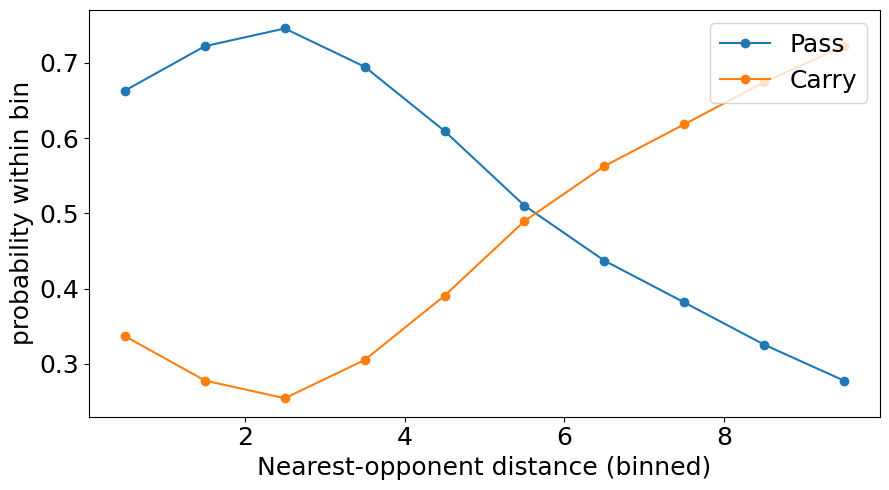

,Carry,Pass,n
dist_bin,,,
"[0, 1)",0.336949,0.663051,1383
"[1, 2)",0.278005,0.721995,3910
"[2, 3)",0.254513,0.745487,5096
"[3, 4)",0.305278,0.694722,5097
"[4, 5)",0.390682,0.609318,4400


In [157]:
import matplotlib.pyplot as plt

def plot_action_probs_by_distance(df, bin_edges=None, min_n_per_bin=200):
    """
    Plot P(Pass) and P(Carry) as a function of nearest opponent distance (binned).
    """
    if bin_edges is None:
        # StatsBomb coords are in a fixed pitch coordinate system; distances in those units
        # Use 0 to 10 with 1-unit bins as a sensible default.
        bin_edges = np.arange(0, 11, 1)

    tmp = df.copy()
    tmp["dist_bin"] = pd.cut(tmp["nearest_opp_dist"], bins=bin_edges, include_lowest=True, right=False)

    counts = tmp.groupby("dist_bin").size().rename("n")
    probs = (
        tmp.groupby(["dist_bin", "type"])
           .size()
           .div(tmp.groupby("dist_bin").size(), level=0)
           .unstack(fill_value=0)
    )

    # Filter sparse bins
    keep_bins = counts[counts >= min_n_per_bin].index
    probs = probs.loc[keep_bins]
    counts = counts.loc[keep_bins]

    # X values = bin midpoints for plotting
    mids = np.array([iv.left + (iv.right - iv.left) / 2 for iv in probs.index])

    plt.figure(figsize=(9, 5))
    if "Pass" in probs.columns:
        plt.plot(mids, probs["Pass"].values, marker="o", label="Pass")
    if "Carry" in probs.columns:
        plt.plot(mids, probs["Carry"].values, marker="o", label="Carry")

    plt.xlabel("Nearest-opponent distance (binned)", fontsize=18)
    plt.ylabel("probability within bin", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    # plt.title("Action selection vs nearest-opponent distance", fontsize=18)
    plt.legend(loc="upper right", fontsize=18)
    plt.tight_layout()
    plt.show()

    return probs.join(counts)

distance_summary = plot_action_probs_by_distance(decision_df, min_n_per_bin=200)
distance_summary.head()


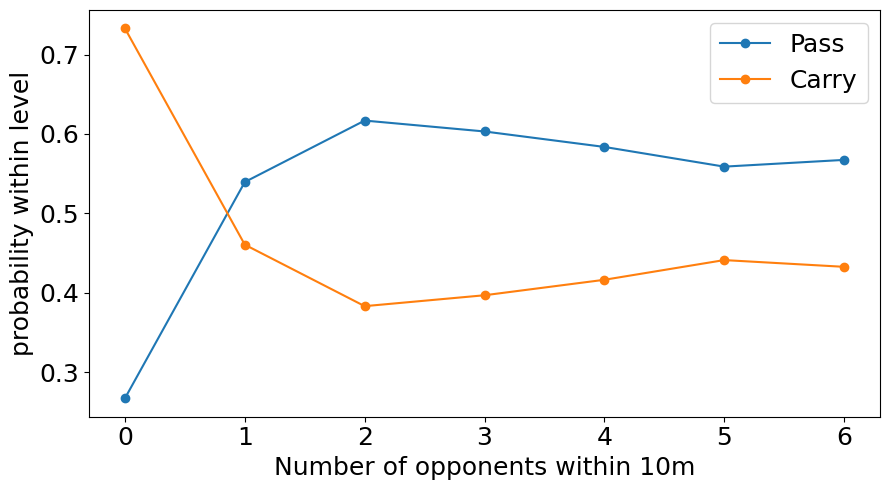

,Carry,Pass,n
dens,,,
0,0.732890,0.267110,6166
1,0.460511,0.539489,12649
2,0.383101,0.616899,9752
3,0.396835,0.603165,6446
4,0.416317,0.583683,2856


In [158]:
def plot_action_probs_by_density(df, max_density=10, min_n_per_level=200):
    """
    Plot P(Pass) and P(Carry) as a function of # opponents within 10m.
    """
    tmp = df.copy()
    tmp["dens"] = tmp["opp_within_10"].astype(int)
    tmp = tmp[tmp["dens"].between(0, max_density)]

    counts = tmp.groupby("dens").size().rename("n")
    probs = (
        tmp.groupby(["dens", "type"])
           .size()
           .div(tmp.groupby("dens").size(), level=0)
           .unstack(fill_value=0)
    )

    keep = counts[counts >= min_n_per_level].index
    probs = probs.loc[keep]
    counts = counts.loc[keep]

    x = probs.index.to_numpy()

    plt.figure(figsize=(9, 5))
    if "Pass" in probs.columns:
        plt.plot(x, probs["Pass"].values, marker="o", label="Pass")
    if "Carry" in probs.columns:
        plt.plot(x, probs["Carry"].values, marker="o", label="Carry")

    plt.xlabel("Number of opponents within 10m", fontsize=18)
    plt.ylabel("probability within level", fontsize=18)
    # plt.title("Action selection vs local defensive density (10m radius)", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(loc="upper right", fontsize=18)
    plt.tight_layout()
    plt.show()

    return probs.join(counts)

density_summary = plot_action_probs_by_density(decision_df, max_density=10, min_n_per_level=200)
density_summary.head()


# Section 4

In [75]:
import numpy as np
import pandas as pd

events_ctx = events_ctx.copy()  # from Section 3

# Extract event x,y again (safe)
def extract_xy(loc):
    if isinstance(loc, (list, tuple)) and len(loc) >= 2:
        x, y = loc[0], loc[1]
        if x is None or y is None:
            return None, None
        return float(x), float(y)
    return None, None

events_ctx["ev_x"] = events_ctx["location"].apply(lambda loc: extract_xy(loc)[0])
events_ctx["ev_y"] = events_ctx["location"].apply(lambda loc: extract_xy(loc)[1])

# Drop rows missing context essentials
events_ctx = events_ctx.dropna(subset=[
    "ev_x", "ev_y",
    "nearest_opp_dist",
    "opp_within_10"
]).copy()


In [76]:
# Keep only on-ball decision events
decision_ctx = events_ctx[events_ctx["type"].isin(["Pass", "Carry"])].copy()

# Ensure player exists
decision_ctx = decision_ctx.dropna(subset=["player"]).copy()

print("Decision events:", len(decision_ctx))
print(decision_ctx[["player", "type", "nearest_opp_dist", "opp_within_10"]].head())


Decision events: 39061
                   player   type  nearest_opp_dist  opp_within_10
6            Nathan Tella   Pass          3.766464            1.0
8          Lukáš Hrádecký  Carry         24.155159            0.0
9          Lukáš Hrádecký   Pass         27.851633            0.0
11  Edmond Fayçal Tapsoba  Carry         25.734167            0.0
14         Robert Andrich  Carry          7.851475            1.0


In [77]:
# Pitch zones (very coarse)
def map_zone(x, y):
    if x < 40:
        return "Defensive third"
    elif x < 80:
        return "Middle third"
    else:
        return "Attacking third"

events_ctx["zone"] = events_ctx.apply(lambda r: map_zone(r["ev_x"], r["ev_y"]), axis=1)

# Nearest-opponent bins
def bin_opponent_dist(d):
    if d <= 5:
        return "0–5m"
    elif d <= 10:
        return "5–10m"
    elif d <= 20:
        return "10–20m"
    else:
        return "20m+"

events_ctx["opp_dist_bin"] = events_ctx["nearest_opp_dist"].apply(bin_opponent_dist)

# Defender density bins
def bin_pressure(n):
    if n == 0:
        return "0"
    elif n <= 2:
        return "1–2"
    elif n <= 4:
        return "3–4"
    else:
        return "5+"

events_ctx["pressure_bin"] = events_ctx["opp_within_10"].apply(bin_pressure)

# Final context ID
events_ctx["context_id"] = (
    events_ctx["zone"] + " | " +
    events_ctx["opp_dist_bin"] + " | " +
    events_ctx["pressure_bin"]
)

display(events_ctx["context_id"].value_counts().head(10))


context_id
Middle third | 5–10m | 1–2       11255
Middle third | 0–5m | 1–2         9805
Middle third | 10–20m | 0         6300
Middle third | 0–5m | 3–4         6247
Attacking third | 0–5m | 3–4      5051
Attacking third | 5–10m | 1–2     5028
Attacking third | 0–5m | 1–2      4927
Defensive third | 0–5m | 1–2      3936
Defensive third | 5–10m | 1–2     2913
Defensive third | 10–20m | 0      2781
Name: count, dtype: int64

In [79]:
# Find context buckets with sufficient data
context_counts = events_ctx["context_id"].value_counts()
common_contexts = context_counts[context_counts >= 200].index.tolist()

print("Top common contexts:")
display(context_counts.head(10))

FOCUS_CONTEXT = common_contexts[0]
print("Using context:", FOCUS_CONTEXT)

ctx_df = events_ctx[events_ctx["context_id"] == FOCUS_CONTEXT].copy()
display(ctx_df[["context_id", "player", "type"]].head())


Top common contexts:


context_id
Middle third | 5–10m | 1–2       11255
Middle third | 0–5m | 1–2         9805
Middle third | 10–20m | 0         6300
Middle third | 0–5m | 3–4         6247
Attacking third | 0–5m | 3–4      5051
Attacking third | 5–10m | 1–2     5028
Attacking third | 0–5m | 1–2      4927
Defensive third | 0–5m | 1–2      3936
Defensive third | 5–10m | 1–2     2913
Defensive third | 10–20m | 0      2781
Name: count, dtype: int64

Using context: Middle third | 5–10m | 1–2


,context_id,player,type
18,Middle third | 5–10m | 1–2,Edmond Fayçal Tapsoba,Pass
27,Middle third | 5–10m | 1–2,Jonathan Tah,Pass
31,Middle third | 5–10m | 1–2,Jonathan Tah,Ball Receipt*
32,Middle third | 5–10m | 1–2,Jonathan Tah,Carry
43,Middle third | 5–10m | 1–2,Odilon Kossonou,Pass


In [80]:
DECISION_TYPES = ["Pass", "Carry"]
MIN_EVENTS = 50

ctx_dec = ctx_df[ctx_df["type"].isin(DECISION_TYPES)].copy()

player_action_dist = (
    ctx_dec
    .groupby(["player", "type"])
    .size()
    .unstack(fill_value=0)
)

player_totals = player_action_dist.sum(axis=1)
player_action_dist = player_action_dist[player_totals >= MIN_EVENTS]

player_action_probs = player_action_dist.div(player_action_dist.sum(axis=1), axis=0)

display(player_action_probs.head(10))
print("Columns:", list(player_action_probs.columns))


type,Carry,Pass
player,,
Alejandro Grimaldo García,0.607940,0.392060
Amine Adli,0.584615,0.415385
Edmond Fayçal Tapsoba,0.480874,0.519126
Exequiel Alejandro Palacios,0.605891,0.394109
Florian Wirtz,0.688976,0.311024
Granit Xhaka,0.677353,0.322647
Jeremie Frimpong,0.666667,0.333333
Jonas Hofmann,0.627306,0.372694
Jonathan Tah,0.486749,0.513251


Columns: ['Carry', 'Pass']


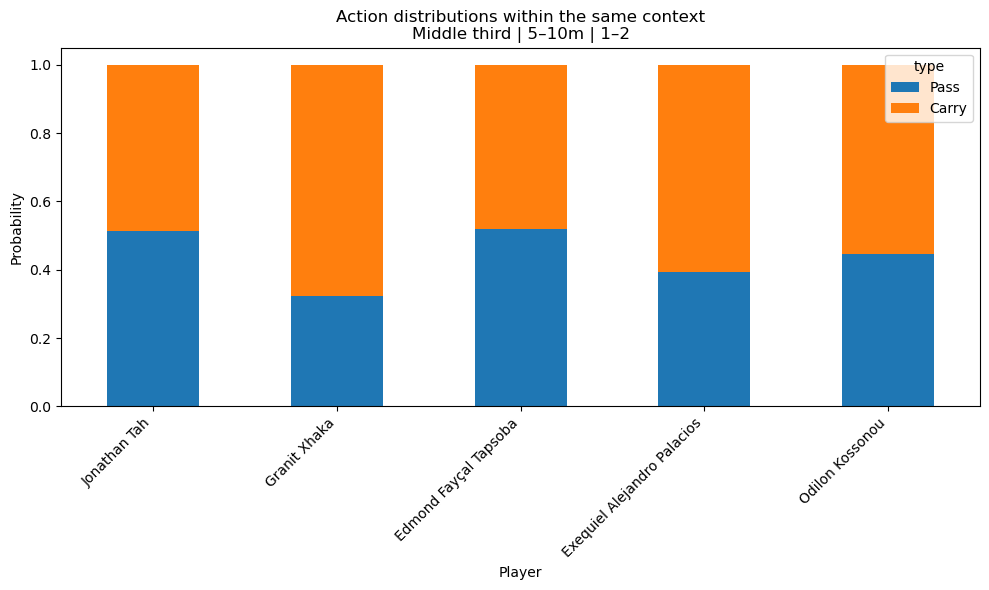

In [81]:
import matplotlib.pyplot as plt

top_players = player_totals.sort_values(ascending=False).head(5).index.tolist()
plot_df = player_action_probs.loc[top_players]

plot_df = plot_df[["Pass", "Carry"]].fillna(0)

plot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

plt.title(f"Action distributions within the same context\n{FOCUS_CONTEXT}")
plt.ylabel("Probability")
plt.xlabel("Player")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [82]:
from scipy.spatial.distance import pdist, squareform

# Use only action-type distributions
action_cols = ["Pass", "Carry"]
action_matrix = player_action_probs[action_cols].fillna(0)

# Pairwise Jensen–Shannon distances (more stable than Euclidean)
from scipy.spatial.distance import jensenshannon

def pairwise_jsd(mat):
    players = mat.index.tolist()
    n = len(players)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i, j] = jensenshannon(mat.iloc[i], mat.iloc[j])
    return pd.DataFrame(D, index=players, columns=players)

jsd_matrix = pairwise_jsd(action_matrix)

display(jsd_matrix.iloc[:6, :6])


,Alejandro Grimaldo García,Amine Adli,Edmond Fayçal Tapsoba,Exequiel Alejandro Palacios,Florian Wirtz,Granit Xhaka
Alejandro Grimaldo García,0.000000,0.016809,0.090333,0.001484,0.060057,0.051241
Amine Adli,0.016809,0.000000,0.073581,0.015325,0.076822,0.068016
Edmond Fayçal Tapsoba,0.090333,0.073581,0.000000,0.088855,0.149954,0.141225
Exequiel Alejandro Palacios,0.001484,0.015325,0.088855,0.000000,0.061538,0.052722
Florian Wirtz,0.060057,0.076822,0.149954,0.061538,0.000000,0.008833
Granit Xhaka,0.051241,0.068016,0.141225,0.052722,0.008833,0.000000


In [83]:
# Bootstrap: split each player's events into two halves and compare

def split_half_jsd(ctx_df, n_boot=50):
    out = []

    for player, g in ctx_df.groupby("player"):
        if len(g) < 100:
            continue

        for _ in range(n_boot):
            g1 = g.sample(frac=0.5, replace=False)
            g2 = g.drop(g1.index)

            def dist(df):
                return df["type"].value_counts(normalize=True)

            p1 = dist(g1)
            p2 = dist(g2)

            all_actions = set(p1.index) | set(p2.index)
            v1 = np.array([p1.get(a, 0) for a in all_actions])
            v2 = np.array([p2.get(a, 0) for a in all_actions])

            out.append({
                "player": player,
                "jsd": jensenshannon(v1, v2)
            })

    return pd.DataFrame(out)

within_jsd = split_half_jsd(ctx_df)

# Between-player distances (sample)
players = action_matrix.index.tolist()
between_jsd = []

for i in range(min(10, len(players))):
    for j in range(i+1, min(10, len(players))):
        between_jsd.append(jsd_matrix.iloc[i, j])

between_jsd = pd.Series(between_jsd)

print("Within-player JSD (median):", round(within_jsd["jsd"].median(), 3))
print("Between-player JSD (median):", round(between_jsd.median(), 3))


Within-player JSD (median): 0.078
Between-player JSD (median): 0.06


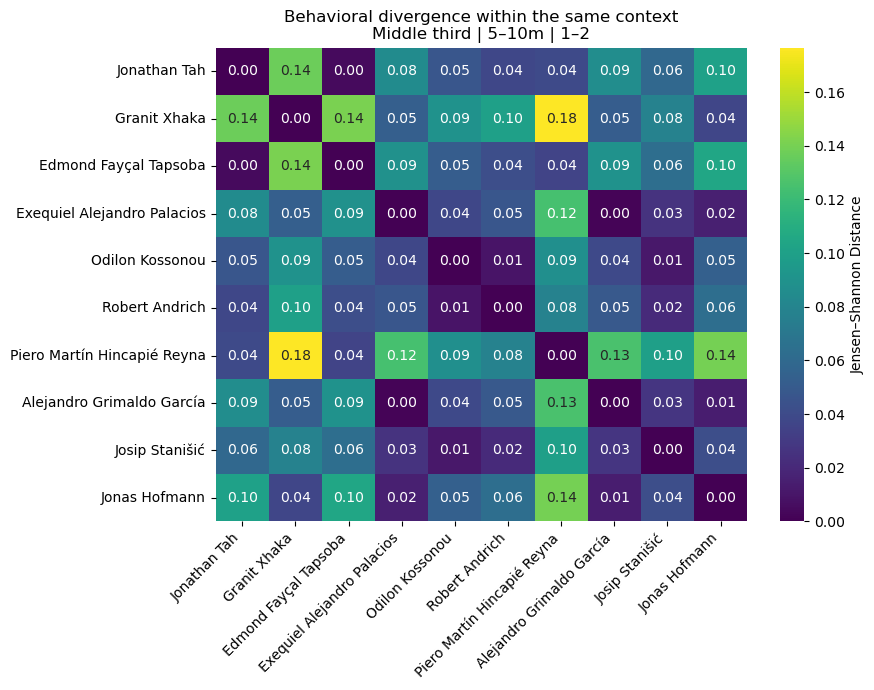

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

# Limit to top-N players for readability
TOP_N = 10
top_players = player_totals.sort_values(ascending=False).head(TOP_N).index.tolist()

jsd_sub = jsd_matrix.loc[top_players, top_players]

plt.figure(figsize=(9, 7))
sns.heatmap(
    jsd_sub,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar_kws={"label": "Jensen–Shannon Distance"}
)
plt.title(f"Behavioral divergence within the same context\n{FOCUS_CONTEXT}")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


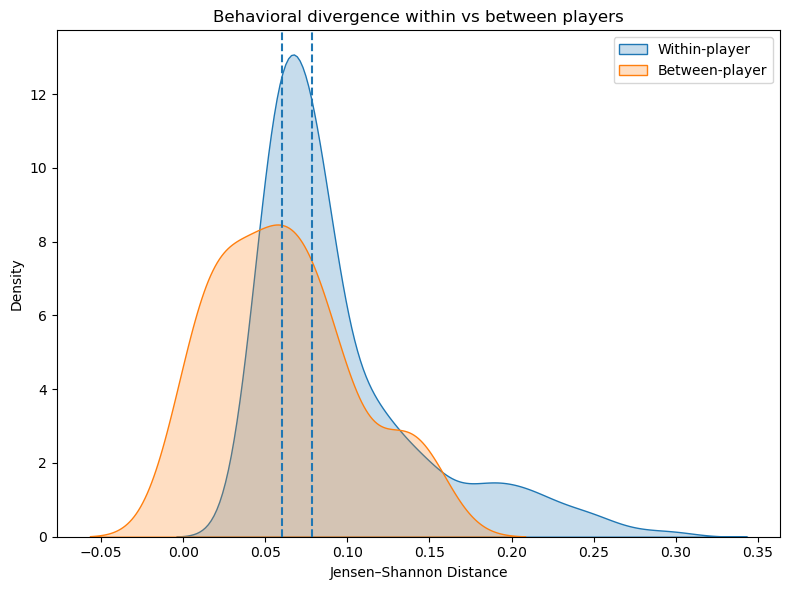

In [85]:
plt.figure(figsize=(8, 6))

sns.kdeplot(within_jsd["jsd"], label="Within-player", fill=True)
sns.kdeplot(between_jsd, label="Between-player", fill=True)

plt.axvline(within_jsd["jsd"].median(), linestyle="--")
plt.axvline(between_jsd.median(), linestyle="--")

plt.title("Behavioral divergence within vs between players")
plt.xlabel("Jensen–Shannon Distance")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


# Section 5

In [86]:
import numpy as np
import pandas as pd

# Use only decision events
DECISION_TYPES = ["Pass", "Carry"]

df = events_ctx.copy()
df = df[df["type"].isin(DECISION_TYPES)].copy()

# Must have match_id; if not, warn
if "match_id" not in df.columns or df["match_id"].isna().all():
    raise ValueError(
        "match_id is missing from events_ctx. "
        "Fix by injecting match_id in load_match_data() and reloading data."
    )

# Per-player, per-match action counts
player_match_actions = (
    df
    .groupby(["player", "match_id", "type"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

display(player_match_actions.head())


type,player,match_id,Carry,Pass
0,Adam Hložek,3895052,2,3
1,Adam Hložek,3895060,1,2
2,Adam Hložek,3895067,9,9
3,Adam Hložek,3895086,3,3
4,Adam Hložek,3895095,4,5


In [87]:
from scipy.spatial.distance import jensenshannon

def compute_match_split_profiles(player_match_actions, min_matches=4):
    """
    For each player:
      - split matches into early vs late halves
      - compute normalized action distributions for each half
      - compute JSD between halves
    """
    rows = []

    for player, g in player_match_actions.groupby("player"):
        matches = sorted(g["match_id"].unique())
        if len(matches) < min_matches:
            continue

        mid = len(matches) // 2
        early_matches = matches[:mid]
        late_matches  = matches[mid:]

        g_early = g[g["match_id"].isin(early_matches)]
        g_late  = g[g["match_id"].isin(late_matches)]

        def dist(df):
            s = df[DECISION_TYPES].sum()
            if s.sum() == 0:
                return None
            return (s / s.sum()).values

        p_early = dist(g_early)
        p_late  = dist(g_late)

        if p_early is None or p_late is None:
            continue

        jsd = jensenshannon(p_early, p_late)

        rows.append({
            "player": player,
            "n_matches": len(matches),
            "jsd_early_late": jsd,
            "p_early_pass": p_early[DECISION_TYPES.index("Pass")],
            "p_late_pass":  p_late[DECISION_TYPES.index("Pass")],
            "p_early_carry": p_early[DECISION_TYPES.index("Carry")],
            "p_late_carry":  p_late[DECISION_TYPES.index("Carry")],
        })

    return pd.DataFrame(rows)


match_split_df = compute_match_split_profiles(player_match_actions, min_matches=4)
display(match_split_df.head())


,player,n_matches,jsd_early_late,p_early_pass,p_late_pass,p_early_carry,p_late_carry
0,Adam Hložek,20,0.040671,0.537313,0.479821,0.462687,0.520179
1,Alejandro Grimaldo García,33,0.006366,0.536653,0.545625,0.463347,0.454375
2,Amine Adli,23,0.033868,0.556075,0.508287,0.443925,0.491713
3,Arthur Augusto de Matos Soares,4,0.009960,0.500000,0.514085,0.500000,0.485915
4,Borja Iglesias Quintas,7,0.034501,0.539326,0.490566,0.460674,0.509434


In [88]:
# Aggregate full-season distributions per player
player_full_dist = (
    player_match_actions
    .groupby("player")[DECISION_TYPES]
    .sum()
)

player_full_probs = player_full_dist.div(
    player_full_dist.sum(axis=1), axis=0
).dropna()

# Sample between-player distances
players = player_full_probs.index.tolist()
between_jsd = []

for i in range(min(12, len(players))):
    for j in range(i + 1, min(12, len(players))):
        v1 = player_full_probs.iloc[i].values
        v2 = player_full_probs.iloc[j].values
        between_jsd.append(jensenshannon(v1, v2))

between_jsd = pd.Series(between_jsd)


In [89]:
print("Early vs Late (within-player) JSD:")
print("  median:", round(match_split_df["jsd_early_late"].median(), 3))
print("  mean:  ", round(match_split_df["jsd_early_late"].mean(), 3))

print("\nBetween-player JSD (baseline):")
print("  median:", round(between_jsd.median(), 3))
print("  mean:  ", round(between_jsd.mean(), 3))

display(
    match_split_df
    .sort_values("jsd_early_late")
    .head(12)
)


Early vs Late (within-player) JSD:
  median: 0.009
  mean:   0.018

Between-player JSD (baseline):
  median: 0.014
  mean:   0.016


,player,n_matches,jsd_early_late,p_early_pass,p_late_pass,p_early_carry,p_late_carry
7,Florian Wirtz,32,0.001800,0.505081,0.502535,0.494919,0.497465
20,Robert Andrich,28,0.003149,0.568588,0.564175,0.431412,0.435825
13,Josip Stanišić,20,0.004012,0.538043,0.532383,0.461957,0.467617
19,Piero Martín Hincapié Reyna,25,0.004158,0.534972,0.540835,0.465028,0.459165
12,Jonathan Tah,31,0.006064,0.538696,0.547240,0.461304,0.452760
1,Alejandro Grimaldo García,33,0.006366,0.536653,0.545625,0.463347,0.454375
8,Granit Xhaka,33,0.006444,0.542538,0.533451,0.457462,0.466549
14,Lukáš Hrádecký,33,0.007020,0.551257,0.561122,0.448743,0.438878
18,Patrik Schick,20,0.007771,0.500000,0.489011,0.500000,0.510989
6,Exequiel Alejandro Palacios,24,0.007806,0.538965,0.527950,0.461035,0.472050


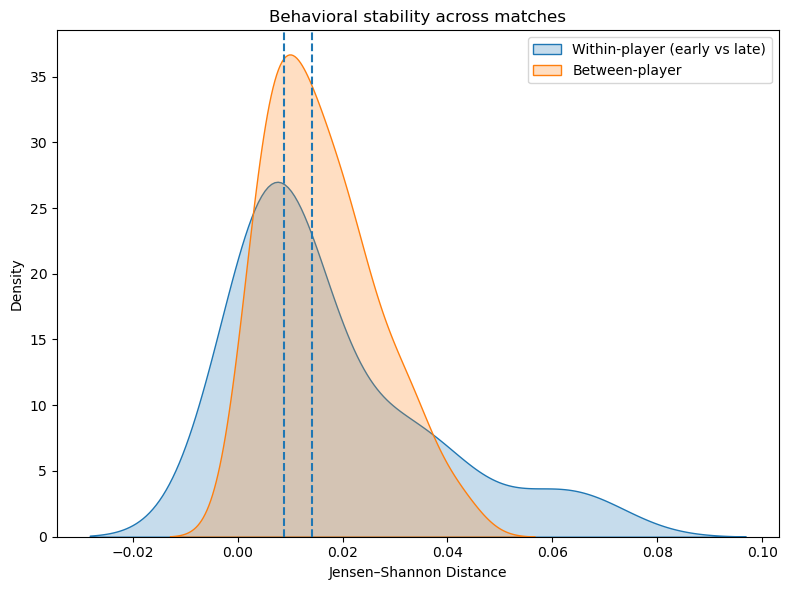

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

sns.kdeplot(match_split_df["jsd_early_late"], label="Within-player (early vs late)", fill=True)
sns.kdeplot(between_jsd, label="Between-player", fill=True)

plt.axvline(match_split_df["jsd_early_late"].median(), linestyle="--")
plt.axvline(between_jsd.median(), linestyle="--")

plt.title("Behavioral stability across matches")
plt.xlabel("Jensen–Shannon Distance")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


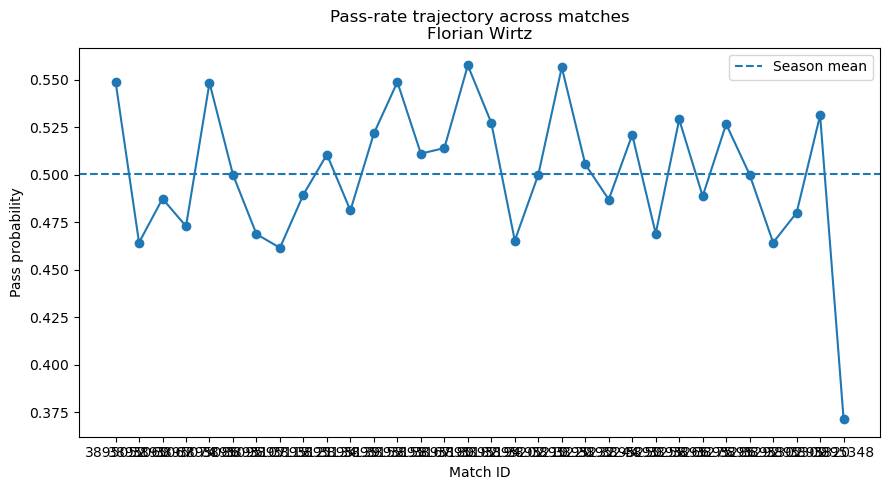

In [91]:
stability_table = (
    match_split_df
    .sort_values("jsd_early_late")
    .assign(stability_rank=lambda d: range(1, len(d) + 1))
)

FOCUS_PLAYER = stability_table.iloc[0]["player"]

player_ts = (
    player_match_actions[player_match_actions["player"] == FOCUS_PLAYER]
    .sort_values("match_id")
    .assign(
        total=lambda d: d["Pass"] + d["Carry"],
        pass_rate=lambda d: d["Pass"] / (d["Pass"] + d["Carry"])
    )
)

plt.figure(figsize=(9, 5))
plt.plot(player_ts["match_id"], player_ts["pass_rate"], marker="o")
plt.axhline(player_ts["pass_rate"].mean(), linestyle="--", label="Season mean")

plt.title(f"Pass-rate trajectory across matches\n{FOCUS_PLAYER}")
plt.xlabel("Match ID")
plt.ylabel("Pass probability")
plt.legend()
plt.tight_layout()
plt.show()


# Section 6

In [92]:
import numpy as np
import pandas as pd

df = events_ctx.copy()

# Aggregate per-player stats
player_agg = (
    df
    .groupby("player")
    .agg(
        n_events=("event_id", "count"),
        n_passes=("type", lambda x: (x == "Pass").sum()),
        n_carries=("type", lambda x: (x == "Carry").sum()),
        pass_completion=("is_complete", "mean"),
        avg_pass_length=("end_location", lambda x: np.nanmean([
            np.linalg.norm(np.array(extract_xy(e)) - np.array(extract_xy(l)))
            for e, l in zip(
                df.loc[x.index, "location"],
                df.loc[x.index, "end_location"]
            )
            if extract_xy(e)[0] is not None and extract_xy(l)[0] is not None
        ]) if len(x) > 0 else np.nan),
        avg_nearest_opponent_dist=("nearest_opponent_dist", "mean"),
        avg_opponents_within_10m=("n_opponents_within_10m", "mean"),
    )
    .reset_index()
)

# Filter to players with meaningful sample size
player_agg = player_agg[player_agg["n_events"] >= 200].copy()

display(player_agg.head())


KeyError: "Column(s) ['n_opponents_within_10m', 'nearest_opponent_dist'] do not exist"

In [ ]:
# action_matrix from Section 4 (Pass / Carry probabilities)
style_df = action_matrix.reset_index().rename(columns={"index": "player"})

player_full = player_agg.merge(style_df, on="player", how="inner")

display(player_full.head())


,player,n_events,n_passes,n_carries,pass_completion,avg_pass_length,avg_nearest_opponent_dist,avg_opponents_within_10m,Pass,Carry
0,Alejandro Grimaldo García,5430,1649,1397,0.808975,11.328456,8.244106,1.614733,0.392060,0.607940
1,Amine Adli,1761,395,362,0.812658,9.798372,9.102616,2.009086,0.415385,0.584615
2,Edmond Fayçal Tapsoba,5167,1658,1482,0.916164,13.157382,8.935887,1.015289,0.519126,0.480874
3,Exequiel Alejandro Palacios,5955,1839,1606,0.922784,9.886909,6.352891,2.040974,0.394109,0.605891
4,Florian Wirtz,6476,1638,1613,0.835775,10.441928,7.332123,2.473749,0.311024,0.688976


In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    player_full["pass_completion"],
    player_full["avg_pass_length"],
    s=80
)

for _, row in player_full.iterrows():
    plt.text(row["pass_completion"] + 0.002,
             row["avg_pass_length"] + 0.2,
             row["player"],
             fontsize=8)

plt.xlabel("Pass completion rate")
plt.ylabel("Average pass length")
plt.title("Traditional player similarity space")
plt.tight_layout()
plt.show()


NameError: name 'player_full' is not defined

<Figure size 800x600 with 0 Axes>

In [94]:
from sklearn.decomposition import PCA

X_style = player_full[["Pass", "Carry"]].values

pca = PCA(n_components=2)
coords = pca.fit_transform(X_style)

style_map = player_full[["player"]].copy()
style_map["PC1"] = coords[:, 0]
style_map["PC2"] = coords[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(style_map["PC1"], style_map["PC2"], s=80)

for _, row in style_map.iterrows():
    plt.text(row["PC1"] + 0.01,
             row["PC2"] + 0.01,
             row["player"],
             fontsize=8)

plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.xlabel("PC1 (behavioral tendency)")
plt.ylabel("PC2 (secondary tendency)")
plt.title("Behavioral style space (context-conditioned)")
plt.tight_layout()
plt.show()


NameError: name 'player_full' is not defined

In [95]:
from scipy.spatial.distance import euclidean

pairs = []

players = player_full["player"].tolist()

for i in range(len(players)):
    for j in range(i + 1, len(players)):
        p1 = player_full.iloc[i]
        p2 = player_full.iloc[j]

        # Stat similarity (z-normalized)
        stat_vec1 = np.array([
            p1["pass_completion"],
            p1["avg_pass_length"]
        ])
        stat_vec2 = np.array([
            p2["pass_completion"],
            p2["avg_pass_length"]
        ])

        # Behavioral dissimilarity
        behav_vec1 = np.array([p1["Pass"], p1["Carry"]])
        behav_vec2 = np.array([p2["Pass"], p2["Carry"]])

        stat_dist = euclidean(stat_vec1, stat_vec2)
        behav_dist = jensenshannon(behav_vec1, behav_vec2)

        pairs.append({
            "player_1": p1["player"],
            "player_2": p2["player"],
            "stat_dist": stat_dist,
            "behav_jsd": behav_dist
        })

pairs_df = pd.DataFrame(pairs)

# Normalize stat distances for interpretability
pairs_df["stat_dist_z"] = (
    (pairs_df["stat_dist"] - pairs_df["stat_dist"].mean()) /
    pairs_df["stat_dist"].std()
)

interesting_pairs = (
    pairs_df
    .sort_values(["stat_dist_z", "behav_jsd"], ascending=[True, False])
    .head(12)
)

display(interesting_pairs)


NameError: name 'player_full' is not defined

In [96]:
plt.figure(figsize=(8, 6))
plt.scatter(
    pairs_df["stat_dist"],
    pairs_df["behav_jsd"],
    alpha=0.6
)

plt.xlabel("Traditional stat distance")
plt.ylabel("Behavioral divergence (JSD)")
plt.title("Mismatch between statistical similarity and behavioral similarity")
plt.tight_layout()
plt.show()


NameError: name 'pairs_df' is not defined

<Figure size 800x600 with 0 Axes>

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Top players by total events (same as before)
player_match_actions = events_ctx.copy()
player_totals = player_match_actions.groupby("player").size()
top_players = player_totals.sort_values(ascending=False).head(5).index.tolist()


In [98]:
# Aggregate action counts
agg_counts = (
    events_df[events_df["type"].isin(["Pass", "Carry"])]
    .groupby(["player", "type"])
    .size()
    .unstack(fill_value=0)
)

# Normalize to probabilities
agg_probs = agg_counts.div(agg_counts.sum(axis=1), axis=0)

# Restrict to same players
agg_plot_df = agg_probs.loc[top_players][["Pass", "Carry"]].fillna(0)


In [99]:
ctx_plot_df = (
    player_action_probs
    .loc[top_players][["Pass", "Carry"]]
    .fillna(0)
)


In [104]:
ctx_n = ctx_df.groupby("player").size().reindex(agg_plot_df.index)

def short_name(full_name):
    parts = full_name.split()
    return parts[-1]

labels = [f"{short_name(p)}\n(n={int(ctx_n.loc[p])})" for p in agg_plot_df.index]

In [102]:
ctx_counts = ctx_df.groupby("player").size().sort_values(ascending=False)
display(ctx_counts)

print("Min / median / max context events:",
      int(ctx_counts.min()), int(ctx_counts.median()), int(ctx_counts.max()))


player
Jonathan Tah                      1710
Granit Xhaka                      1674
Exequiel Alejandro Palacios       1194
Edmond Fayçal Tapsoba             1106
Odilon Kossonou                    907
Robert Andrich                     874
Piero Martín Hincapié Reyna        772
Alejandro Grimaldo García          675
Josip Stanišić                     566
Jonas Hofmann                      500
Florian Wirtz                      483
Jeremie Frimpong                   261
Amine Adli                         122
Victor Okoh Boniface               107
Nathan Tella                        76
Patrik Schick                       53
Nadiem Amiri                        49
Arthur Augusto de Matos Soares      40
Adam Hložek                         39
Gustavo Adolfo Puerta Molano        23
Borja Iglesias Quintas              13
Noah Mbamba                          9
Lukáš Hrádecký                       1
dtype: int64

Min / median / max context events: 1 261 1710


In [106]:
# Use the most stable players by context volume
ctx_counts = ctx_df.groupby("player").size().sort_values(ascending=False)
top_players = ctx_counts.head(5).index.tolist()
top_players


['Jonathan Tah',
 'Granit Xhaka',
 'Exequiel Alejandro Palacios',
 'Edmond Fayçal Tapsoba',
 'Odilon Kossonou']

In [108]:
agg_counts = (
    decision_ctx
    .groupby(["player", "type"])
    .size()
    .unstack(fill_value=0)
)

agg_probs = agg_counts.div(agg_counts.sum(axis=1), axis=0)

agg_plot_df = agg_probs.reindex(top_players)[["Pass", "Carry"]].fillna(0)
display(agg_plot_df)
ctx_counts_pc = (
    ctx_df
    .groupby(["player", "type"])
    .size()
    .unstack(fill_value=0)
)

ctx_probs = ctx_counts_pc.div(ctx_counts_pc.sum(axis=1), axis=0)

ctx_plot_df = ctx_probs.reindex(top_players)[["Pass", "Carry"]].fillna(0)
display(ctx_plot_df)


type,Pass,Carry
player,,
Jonathan Tah,0.543262,0.456738
Granit Xhaka,0.537953,0.462047
Exequiel Alejandro Palacios,0.533817,0.466183
Edmond Fayçal Tapsoba,0.528025,0.471975
Odilon Kossonou,0.528903,0.471097


type,Pass,Carry
player,,
Jonathan Tah,0.339766,0.322222
Granit Xhaka,0.186380,0.391278
Exequiel Alejandro Palacios,0.235343,0.361809
Edmond Fayçal Tapsoba,0.343580,0.318264
Odilon Kossonou,0.281147,0.348401


In [109]:
def last_name(full_name: str) -> str:
    if not isinstance(full_name, str) or full_name.strip() == "":
        return full_name
    return full_name.strip().split()[-1]

agg_plot_df_ln = agg_plot_df.copy()
ctx_plot_df_ln = ctx_plot_df.copy()

agg_plot_df_ln.index = [last_name(p) for p in agg_plot_df_ln.index]
ctx_plot_df_ln.index = [last_name(p) for p in ctx_plot_df_ln.index]

display(agg_plot_df_ln)
display(ctx_plot_df_ln)


type,Pass,Carry
Tah,0.543262,0.456738
Xhaka,0.537953,0.462047
Palacios,0.533817,0.466183
Tapsoba,0.528025,0.471975
Kossonou,0.528903,0.471097


type,Pass,Carry
Tah,0.339766,0.322222
Xhaka,0.186380,0.391278
Palacios,0.235343,0.361809
Tapsoba,0.343580,0.318264
Kossonou,0.281147,0.348401


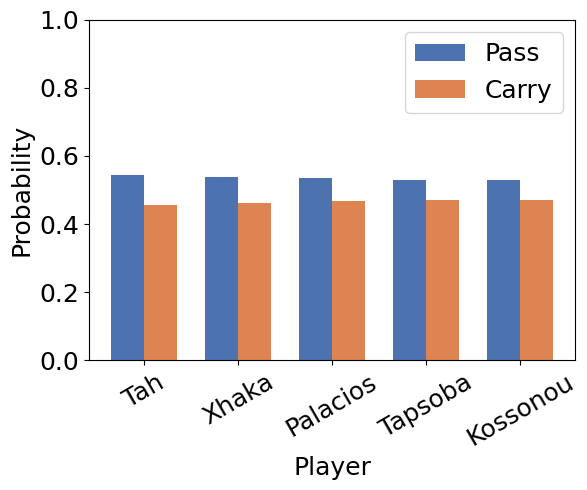

In [155]:
PASS_COLOR = "#4C72B0"
CARRY_COLOR = "#DD8452"

fig, ax = plt.subplots(figsize=(6, 5))

x = np.arange(len(agg_plot_df_ln.index))
width = 0.35

ax.bar(x - width/2, agg_plot_df_ln["Pass"], width, label="Pass", color=PASS_COLOR)
ax.bar(x + width/2, agg_plot_df_ln["Carry"], width, label="Carry", color=CARRY_COLOR)

ax.set_ylabel("Probability", fontsize=18)
ax.set_xlabel("Player", fontsize=18)
ax.set_ylim(0, 1)
# make y tick font size 18
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(ax.get_yticks(), fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(agg_plot_df_ln.index, rotation=30, fontsize=18)
ax.legend(loc="upper right", fontsize=18)

plt.tight_layout()
plt.show()


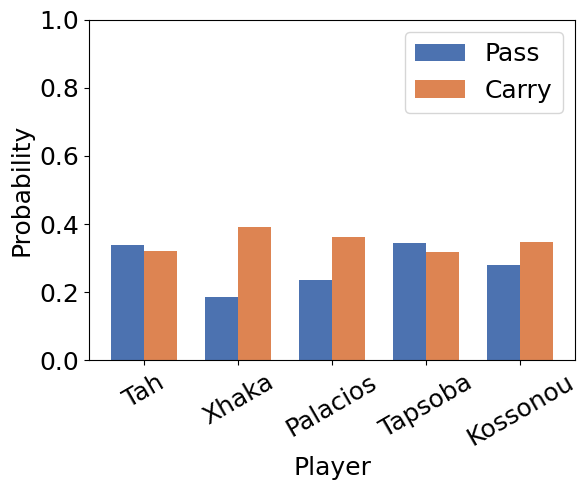

In [156]:
fig, ax = plt.subplots(figsize=(6, 5))

x = np.arange(len(ctx_plot_df_ln.index))
width = 0.35

ax.bar(
    x - width/2,
    ctx_plot_df_ln["Pass"],
    width,
    label="Pass",
    color=PASS_COLOR
)

ax.bar(
    x + width/2,
    ctx_plot_df_ln["Carry"],
    width,
    label="Carry",
    color=CARRY_COLOR
)

ax.set_ylabel("Probability", fontsize=18)
ax.set_xlabel("Player", fontsize=18)
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(ax.get_yticks(), fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(ctx_plot_df_ln.index, rotation=30, fontsize=18)
ax.legend(loc="upper right", fontsize=18)

plt.tight_layout()
plt.show()
